# Test Misc Functions
This notebook contains snippets of code used to test various functions. 

Some functions take the source data as input to perform operations. This assumes that the data processing has been done, please check paths.

Some functions generate output files, which are stored in the folder data/samples/<some name>. If this does not exist, an error will be thrown, generate this folder first.

## Test Edge Detection on Depth

Loading img 1


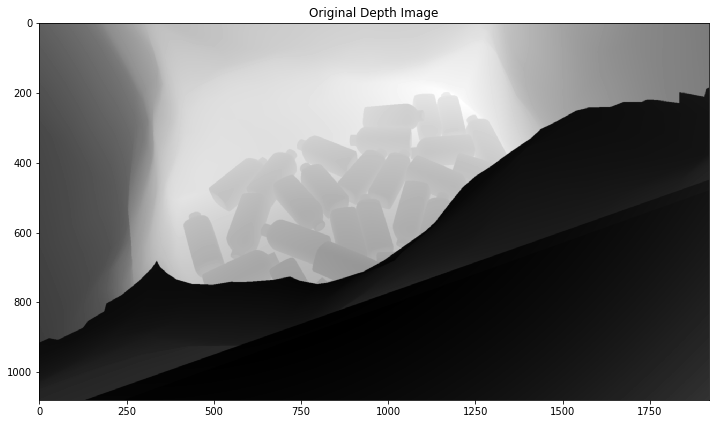

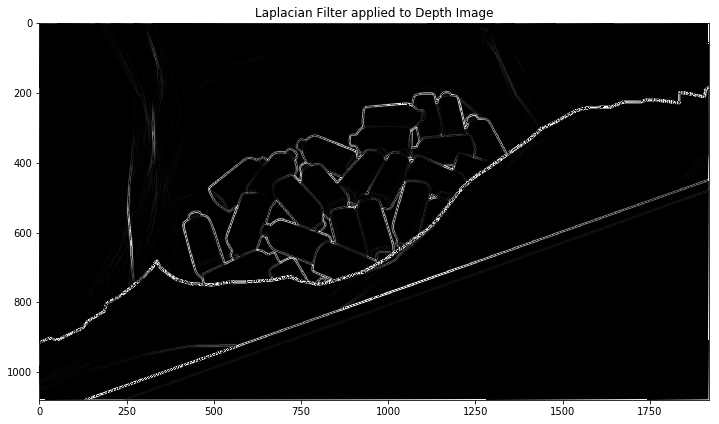

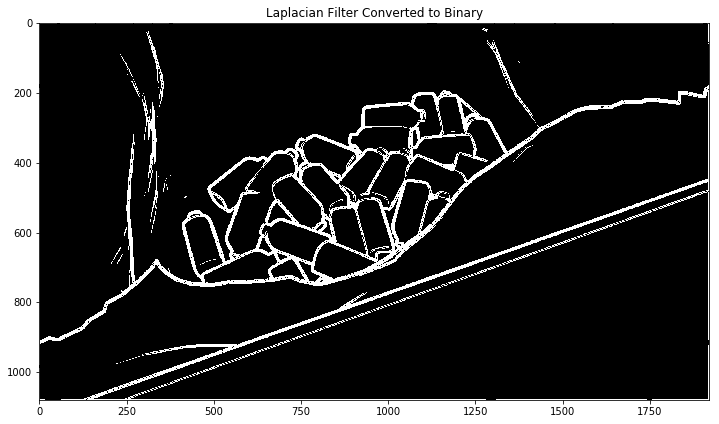

Loading img 2


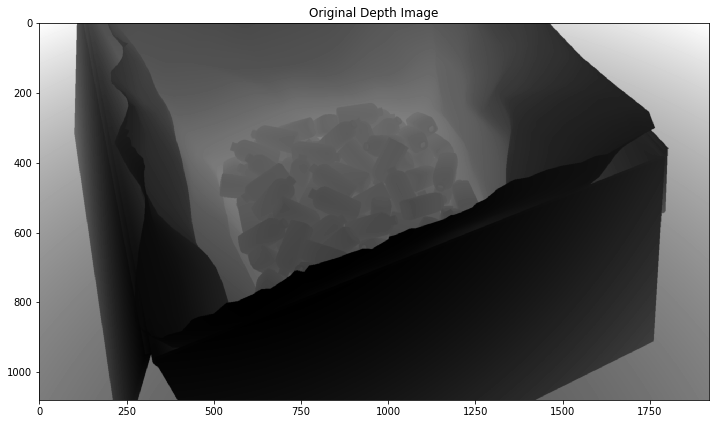

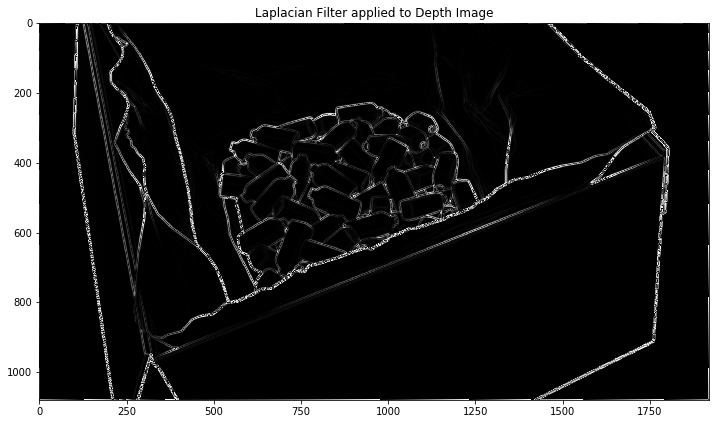

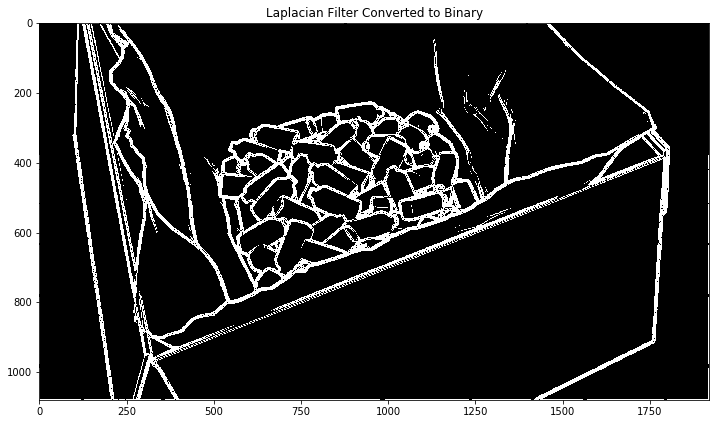

Loading img 3


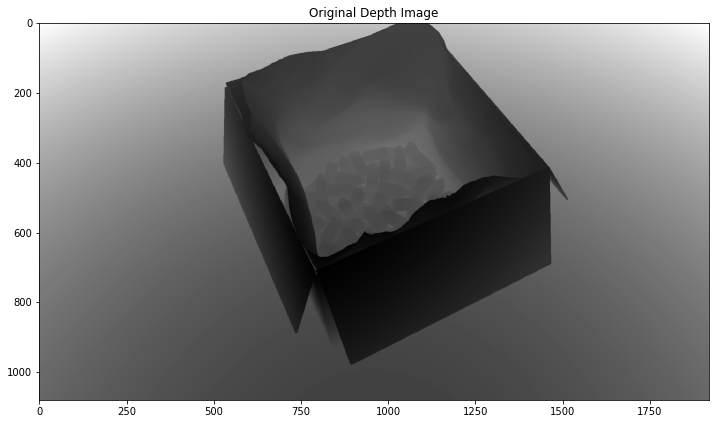

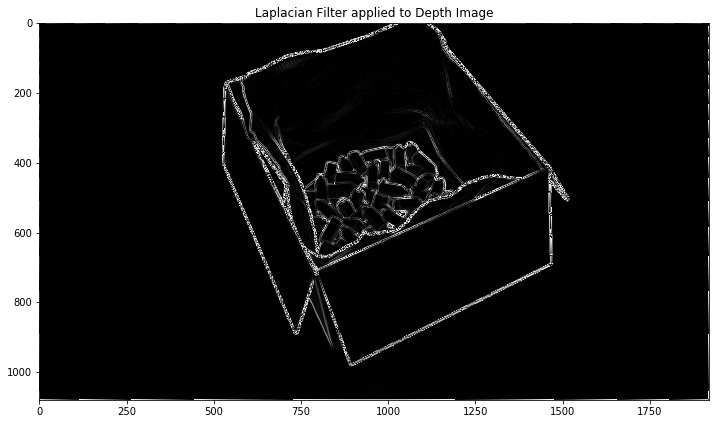

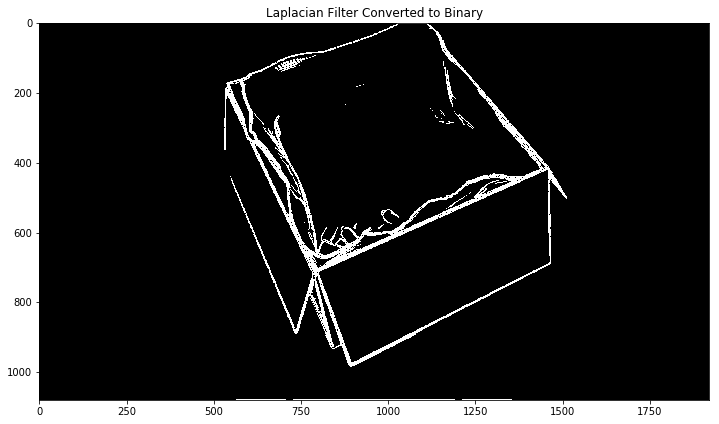

Loading img 4


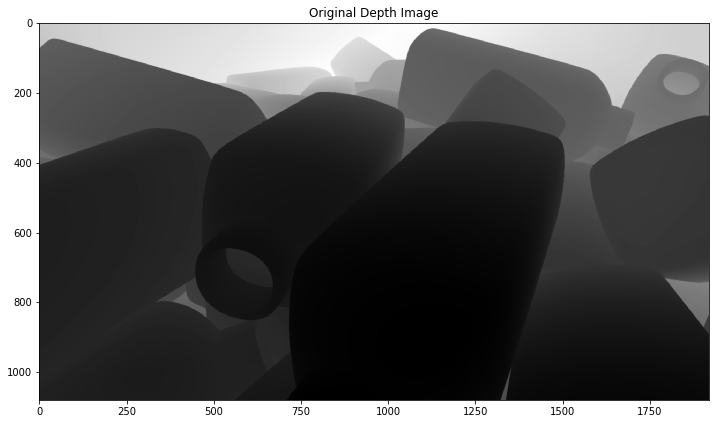

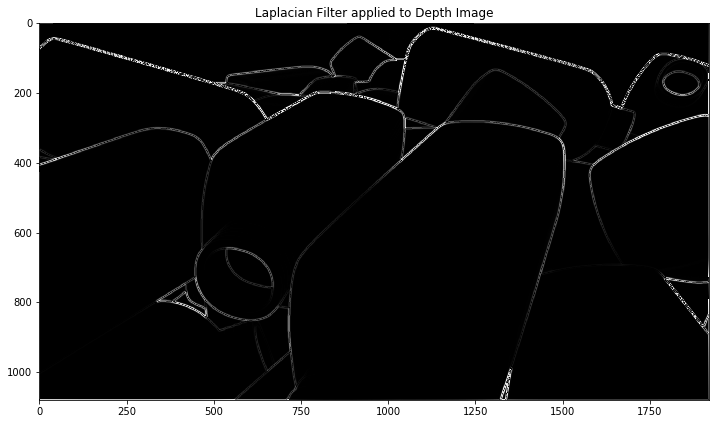

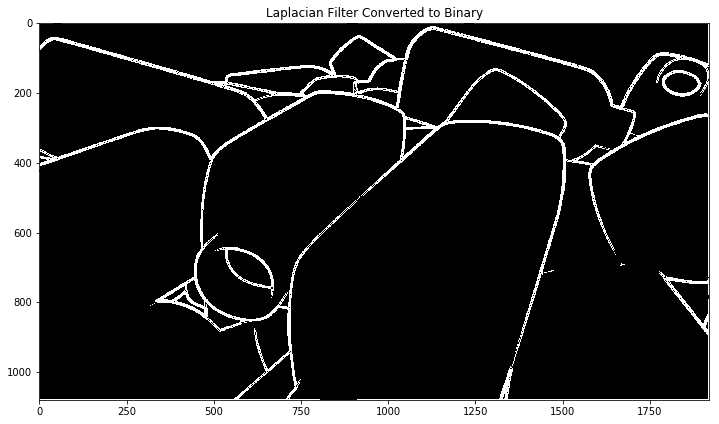

Loading img 5


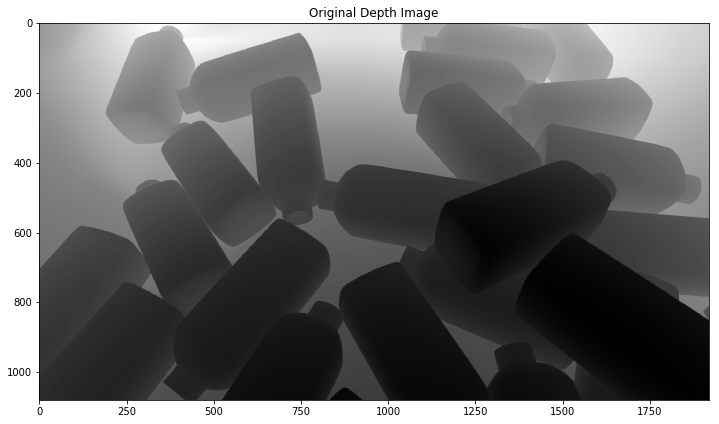

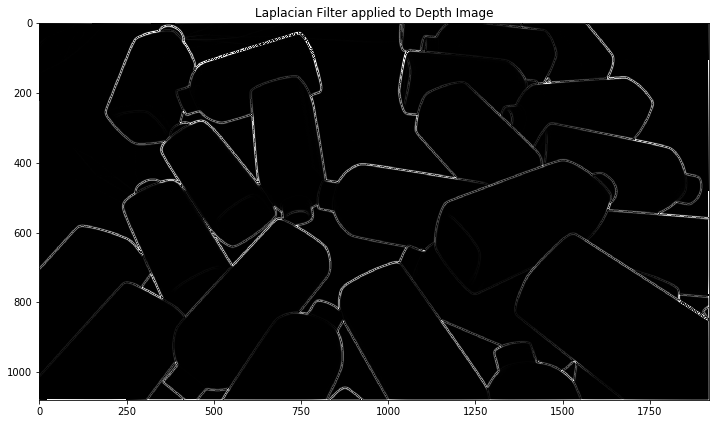

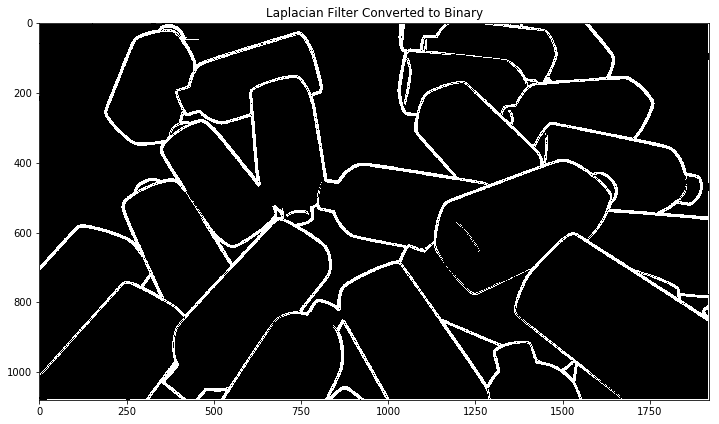

Loading img 6


OSError: Cannot read image file "data/datasets/milk-250/source-files/depth-imgs/000000006-depth.exr". No such file or directory.

In [116]:
%matplotlib inline 

import cv2
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from data_loader import Dataset
import OpenEXR, Imath
import imageio

import sys
sys.path.append('../pytorch-normals/')
from utils.utils import exr_loader, exr_saver

display_output = True
save_output = True

depth_path = 'data/datasets/milk-250/source-files/depth-imgs/%09d-depth.exr'
edges_output_path = 'data/samples/outlines-depth/%09d-depth-edges.jpg'

if not (os.path.isdir(os.path.dirname(depth_path))):
    raise ValueError('The folder %s does not exist. Please check path.'%(os.path.dirname(depth_path)))
if(save_output):
    if not (os.path.isdir(os.path.dirname(edges_output_path))):
        raise ValueError('The folder %s does not exist. Please check path.'%(os.path.dirname(edges_output_path)))

for i in range (1,100):
    # Load Depth Img and Apply Blur
    print('Loading img %d'%(i))
    depth_img_orig = exr_loader(depth_path%(i), ndim=1)
    depth_img_orig = cv2.GaussianBlur(depth_img_orig,(5,5),0)
    
    # Make all depth values greater than 2.5m as 0 (for masking edge matrix)
    depth_img_mask = depth_img_orig.copy()
    depth_img_mask[depth_img_mask > 2.5]=0
    depth_img_mask[depth_img_mask > 0 ]=1
    
    # Apply Laplacian filters for edge detection
    # Laplacian Parameters
    kernel_size = 9
    threshold = 10
    max_depth_to_object = 2.5
    
    edges_lap = cv2.Laplacian(depth_img_orig, cv2.CV_64F, ksize=kernel_size, borderType=0 )
    edges_lap = (np.absolute(edges_lap).astype(np.uint8))
        
    edges_lap_binary = np.zeros(edges_lap.shape, dtype=np.uint8)
    edges_lap_binary[edges_lap > threshold] = 255
    edges_lap_binary[depth_img_orig > max_depth_to_object] = 0
    
    
    if(display_output):
        fig1 = plt.figure(figsize=(12,12))
        plt.title('Original Depth Image')
        plt.imshow(depth_img_orig, cmap='gray')
        plt.show()
        fig2 = plt.figure(figsize=(12,12))
        plt.title('Laplacian Filter applied to Depth Image')
        plt.imshow(edges_lap, cmap='gray')
        plt.show()
        fig3 = plt.figure(figsize=(12,12))
        plt.title('Laplacian Filter Converted to Binary')
        plt.imshow(edges_lap_binary, cmap='gray')
        plt.show()

    if(save_output):
        imageio.imsave( edges_output_path%(i), edges_lap_binary )



# Test Edge Detection on Surface Normals

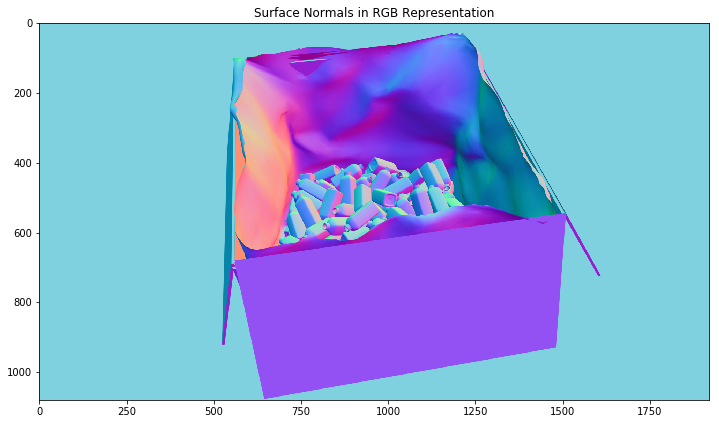

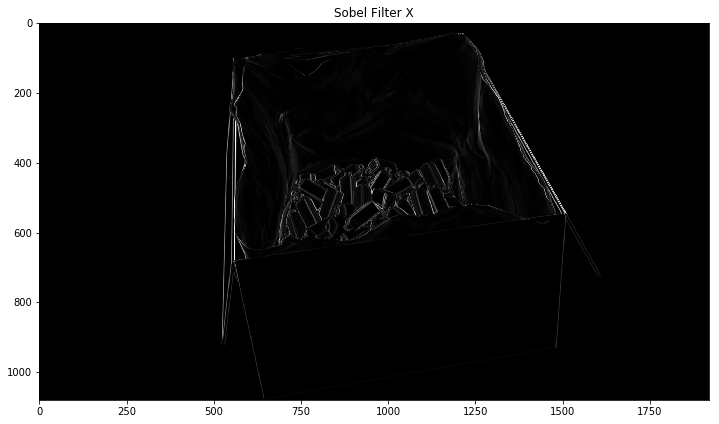

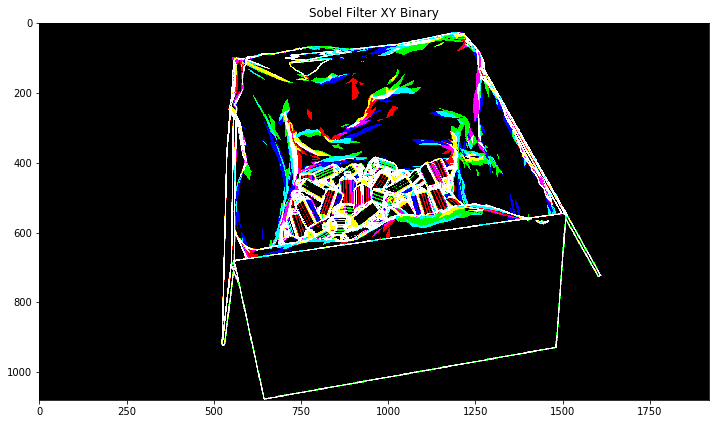

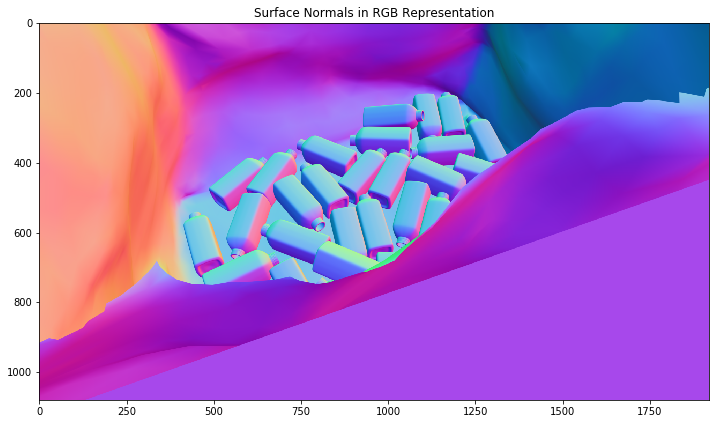

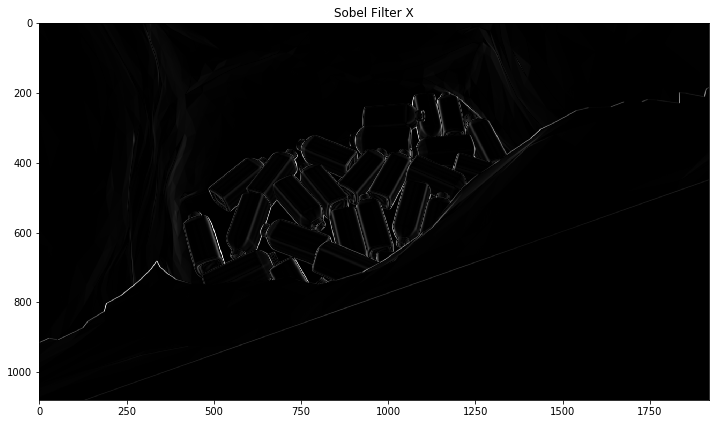

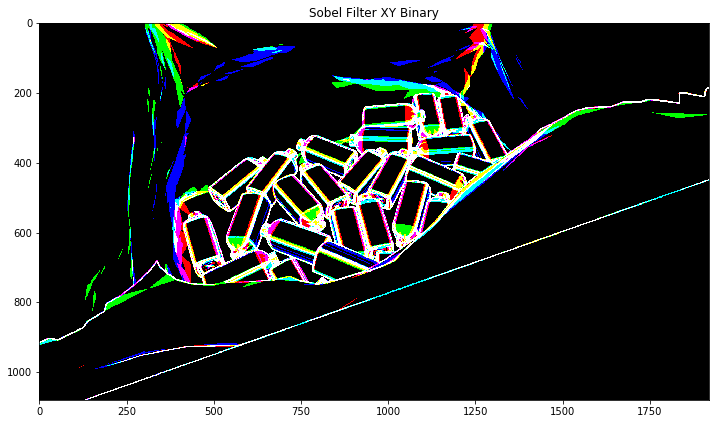

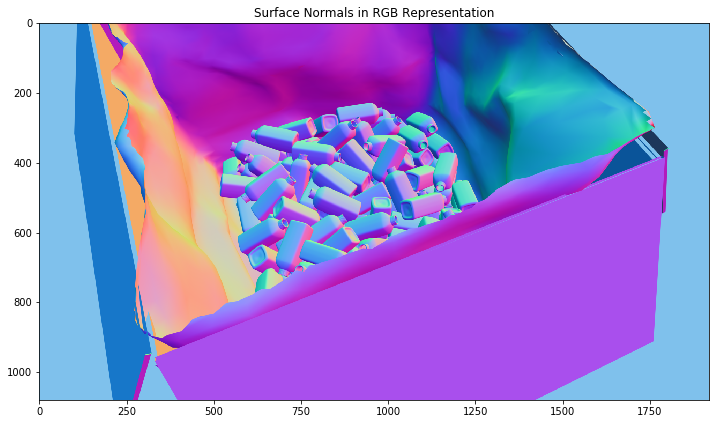

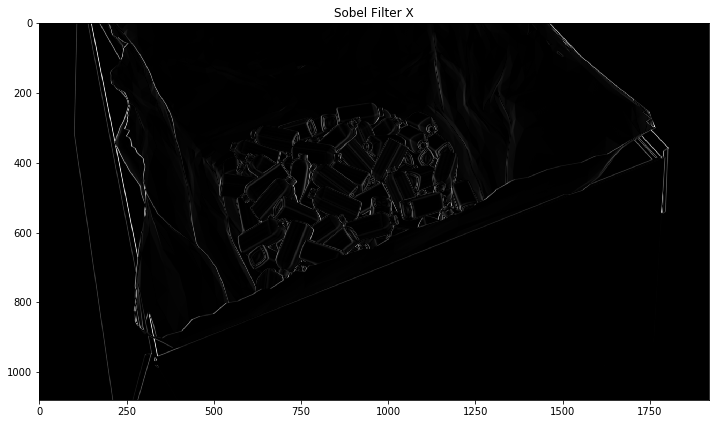

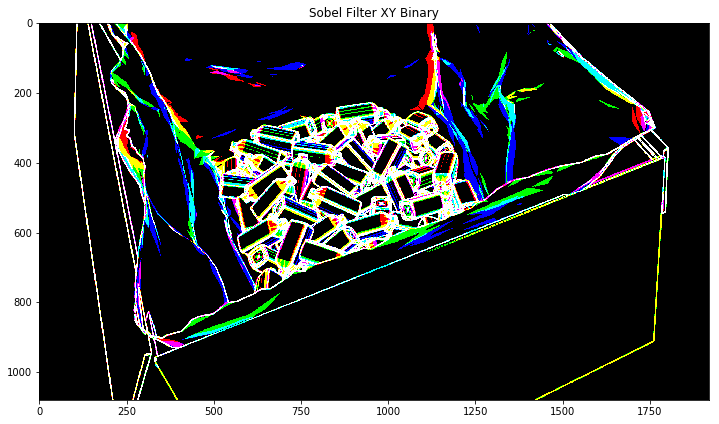

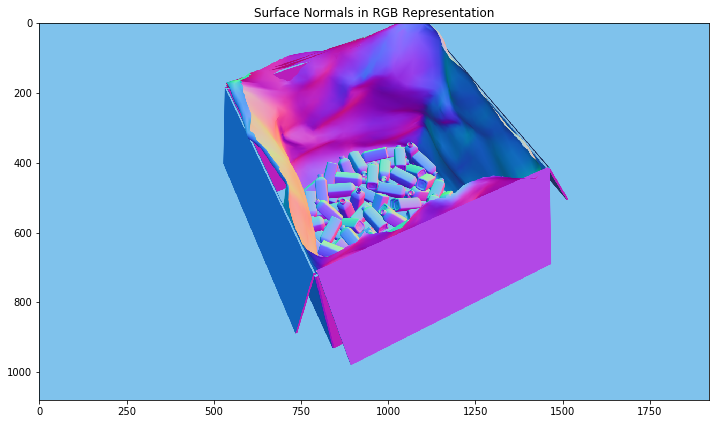

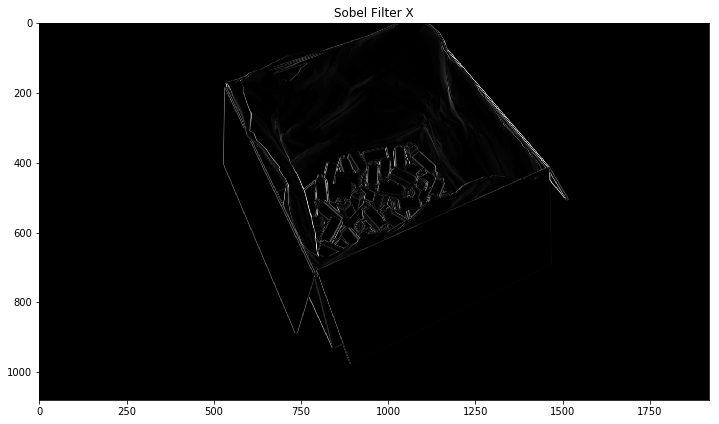

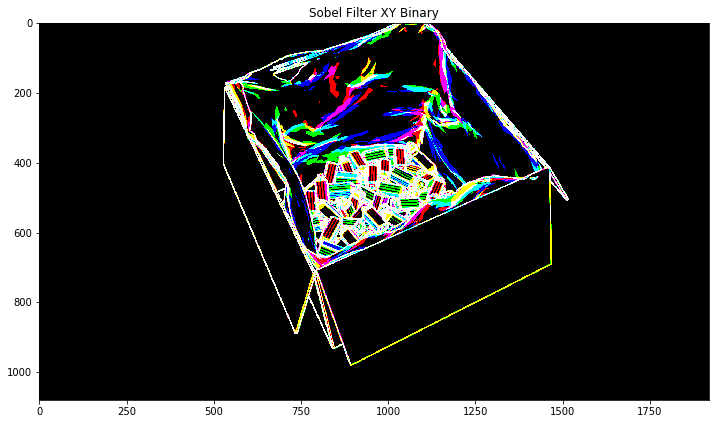

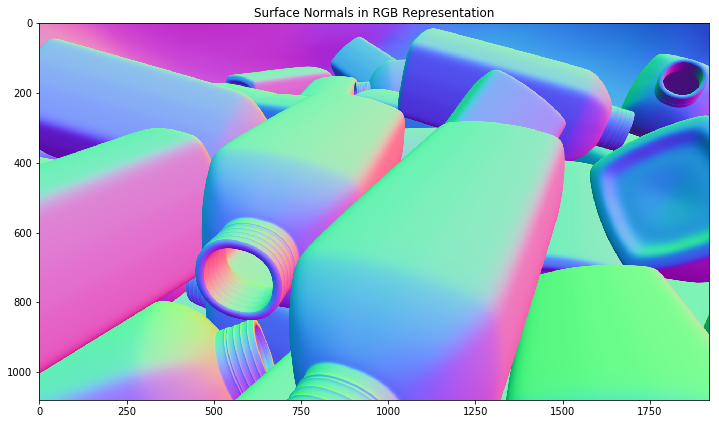

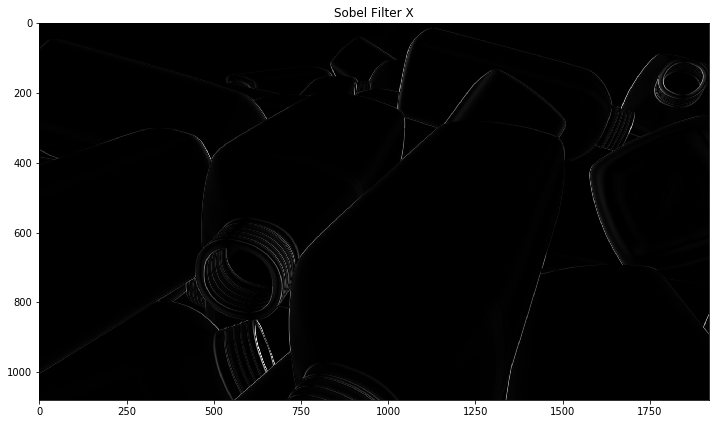

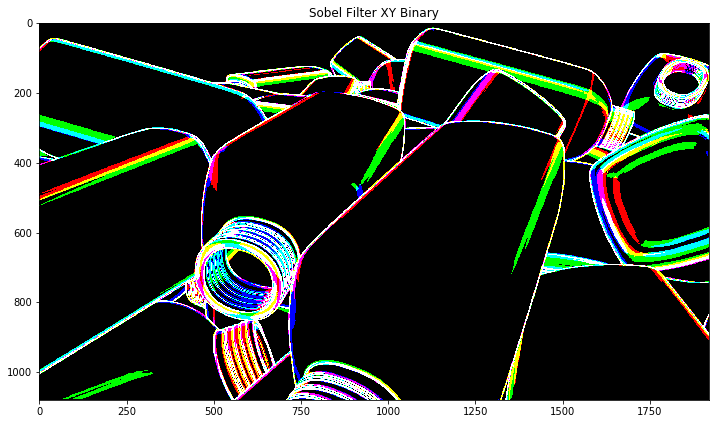

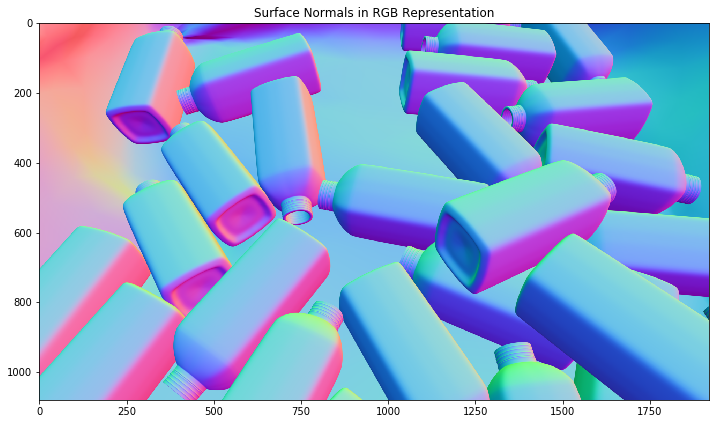

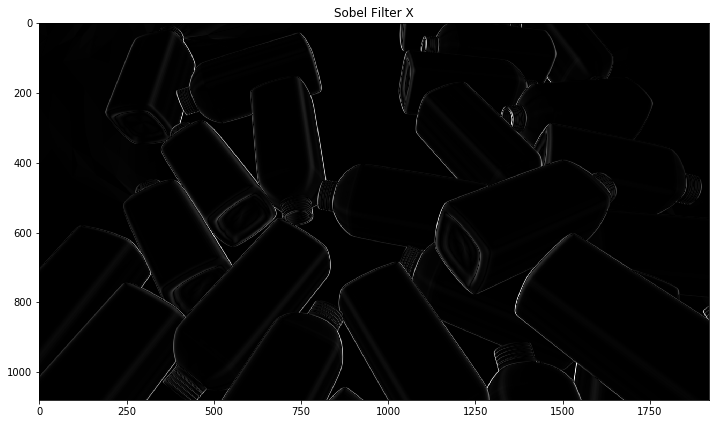

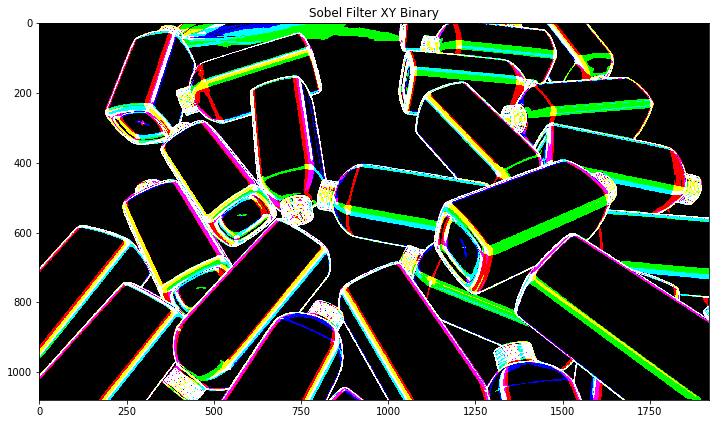

In [107]:
%matplotlib inline 

import os
import glob
import sys
sys.path.append('../pytorch-normals/')

import cv2
import numpy as np
import matplotlib.pyplot as plt
import OpenEXR, Imath
import imageio

from utils.utils import exr_loader


display_output = True
save_output = False

path_surface_normal = 'data/datasets/milk-250/source-files/camera-normals/*cameraNormals.exr'
path_surface_normal_rgb = 'data/datasets/milk-250/source-files/camera-normals/rgb-visualizations/*cameraNormals.png'
edges_output_path = 'data/samples/edges-normals-imgs/%09d-normals-edges.jpg'

if not (os.path.isdir(os.path.dirname(path_surface_normal))):
    raise ValueError('The folder %s does not exist. Please check path.'%(os.path.dirname(path_surface_normal_rgb)))
if not (os.path.isdir(os.path.dirname(path_surface_normal_rgb))):
    raise ValueError('The folder %s does not exist. Please check path.'%(os.path.dirname(path_surface_normal_rgb)))
if(save_output):
    if not (os.path.isdir(os.path.dirname(edges_output_path))):
        raise ValueError('The folder %s does not exist. Please check path.'%(os.path.dirname(edges_output_path)))

# TODO: LOAD IN SOURCE FILES AND CONVERT THEM INTO THE PRE-PROCESSED OUTPUT THIS CODE EXPECTS
input_file_list = sorted(glob.glob(path_surface_normal))
for i in range (0, len(input_file_list)):
    # Load Surface Normal and convert to 16bit image
    surface_normal = exr_loader(input_file_list[i])
    surface_normal = (surface_normal + 1)/2 # convert to [0,1] range
    
    surface_normal_rgb16 = (surface_normal * 65535).astype(np.uint16)
    surface_normal_rgb8 = (surface_normal * 255).astype(np.uint8).transpose((1,2,0))

    # Take each channel of RGB image one by one, apply gradient and combine
    sobelxy_list = []
    for surface_normal_gray in surface_normal_rgb16:
        # Sobel Filter Params
        # These params were chosen using trial and error.
        # NOTE!!!! The max value of sobel output increases exponentially with increase in kernel size.
        # Print the min/max values of array below to get an idea of the range of values in Sobel output.
        kernel_size = 5 
        threshold = 60000
        
        
        # Apply Sobel Filter
        sobelx = cv2.Sobel(surface_normal_gray, cv2.CV_32F,1,0,ksize=kernel_size)
        sobely = cv2.Sobel(surface_normal_gray, cv2.CV_32F,0,1,ksize=kernel_size)
#         print('\ntype0', sobelx.dtype, sobely.dtype)
#         print('min', np.amin(sobelx), np.amin(sobely))
#         print('max', np.amax(sobelx), np.amax(sobely))
        
        sobelx = np.abs(sobelx)
        sobely = np.abs(sobely)
#         print('\ntype1', sobelx.dtype, sobely.dtype)
#         print('min', np.amin(sobelx), np.amin(sobely))
#         print('max', np.amax(sobelx), np.amax(sobely))
        
        # Convert to binary 
        sobelx_binary = np.full(sobelx.shape, False, dtype=bool)
        sobelx_binary[sobelx>=threshold] = True
        
        sobely_binary = np.full(sobely.shape, False, dtype=bool)
        sobely_binary[sobely>=threshold] = True
        
        sobelxy_binary = np.logical_or(sobelx_binary, sobely_binary)
        sobelxy_list.append(sobelxy_binary)
        
    
    sobelxy_binary3d = np.array(sobelxy_list).transpose((1,2,0))
    sobelxy_binary3d = sobelxy_binary3d.astype(np.uint8) * 255

    if(display_output):
        fig0 = plt.figure(figsize=(12,12))
        plt.title('Surface Normals in RGB Representation')
        plt.imshow(surface_normal_rgb8)
        plt.show()
        fig1 = plt.figure(figsize=(12,12))
        plt.title('Sobel Filter X')
        plt.imshow(sobelx, cmap='gray')
        plt.show()
        fig2 = plt.figure(figsize=(12,12))
        plt.title('Sobel Filter XY Binary')
        plt.imshow(sobelxy_binary3d, cmap='gray')
        plt.show()

    
    
    if(save_output):
        imageio.imsave( edges_output_path%(i), edges_lap_binary )



# Test the Pixel Values within Original depth2depth Weights examples,
# Generate and save own weights

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image 
import imageio
from matplotlib import interactive
interactive(True)
%matplotlib qt  
# %matplotlib inline 

# read in outlines/weights file
prefix = 'realsense_004'
path_outlines = 'data/depth2depth_sample_files/bound_realsense_test_bound/'+prefix+'_bound_est.png'
path_weights = 'data/depth2depth_sample_files/bound_realsense_weight/'+prefix+'_weight.png'
weight_save_path = 'data/depth2depth_sample_files/my_generated_weights/'+prefix+'_weight.png'

outlines = Image.open(path_outlines)
outlines = np.array(outlines)
weight_orig = Image.open(path_weights)
weight_orig = np.array(weight_orig)


# Create own weights
outlines = outlines.astype(np.float64)/255
weight = (1-outlines[:,:,1])
weight = np.power(weight,3)
weight = np.multiply(weight,1000)
weight = np.rint(weight)
weight = weight.astype(np.uint16)

print('The two weights are equal = ', np.array_equal(weight_orig, weight))
print('orig weights:\n', weight_orig)
print('my weights:\n', weight)

# Save my weights
array_buffer = weight.tobytes()
img = Image.new("I", weight.T.shape)
img.frombytes(array_buffer, 'raw', 'I;16')
img.save(weight_save_path)
weight_from_file = Image.open(weight_save_path)
weight_from_file = np.array(weight_from_file)
print('My gen weights and weights from file are equal: ', np.array_equal(weight, weight_from_file))

# Create interactive plot to analyze pixel values
fig = plt.figure(figsize=(8, 6))
ax0 = plt.subplot(141)
ax1 = plt.subplot(142)
ax2 = plt.subplot(143)
ax3 = plt.subplot(144)

ax0.imshow(outlines)
ax0.set_title('Predicted Outlines')
ax1.imshow(weight_orig)
ax1.set_title('Orig Weights from \n Outlines')
ax2.imshow(weight)
ax2.set_title('My Weights from \n Outlines')
ax3.imshow(weight_from_file)
ax3.set_title('My Saved Weights')
    
plt.show()


    